In [1]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3

from shapely import geometry

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures


sys.path.append('../analysis/physiology/')
import tpc

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:42757 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Use $T_\mathrm{opt}$ model to extrapolate performance. 

In [this other notebook](./physiology/geographic_TPC_patterns.ipynb) I fit curves to the phytoplankton perfomance parameters, and the following relationship seems promising: 

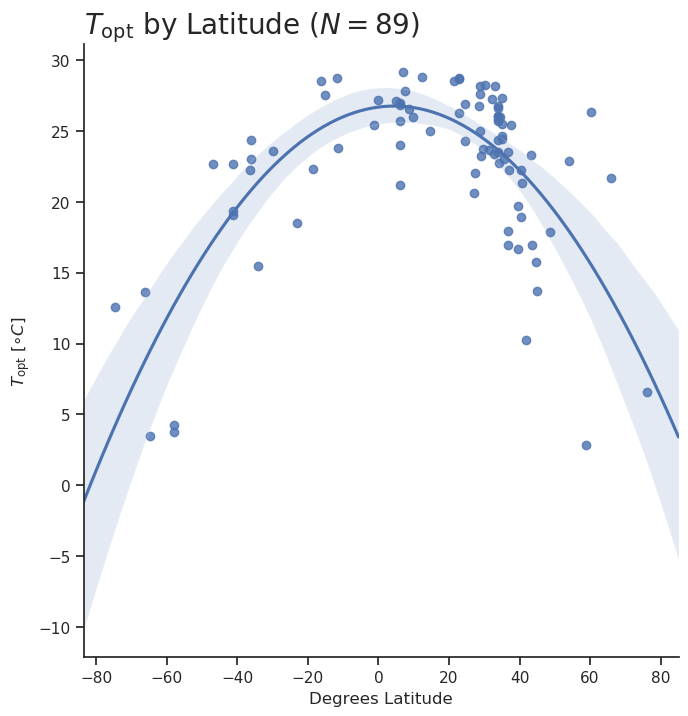

We'll use this relationship to compute difference from $T_\mathrm{opt}$ during MHW events + other times. 

## Load Model & Data

In [3]:
# Load Model
topt_poly = sm.load("physiology/latitude_polynomial_topt.model")

In [4]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [8]:
## Set up Plotting
CENTRAL_LONGITUDE = ((mhws.lon.max() + mhws.lon.min()) / 2).values
CENTRAL_LATITUDE = ((mhws.lat.max() + mhws.lat.min()) / 2).values
PLOT_MAP_PROJECTION = ccrs.Stereographic(central_longitude=CENTRAL_LONGITUDE)
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

## Define Thermal Performance Metric

Here, we'll compute the thermal performance metric $M$ as follows, where $f$ is the polynomial function above giving modeled $T_\mathrm{opt}$ by latitude: $$M(T, \mathrm{lat}) = f(\mathrm{lat}) - T$$
This we can refer to as "departure from $T_\mathrm{opt}$". 

In [9]:
topt = xr.full_like(oisst_pnw.isel(time=0), fill_value=0.).drop('time').rename_vars({'sst' : "Topt"})
topt.attrs = {}

### Compute Topt latitudinally

In [15]:
X = PolynomialFeatures(2).fit_transform(abs(topt.lat.values.reshape(-1, 1)))
_topt = topt_poly.predict(X)
for _data, lat in zip(_topt, topt.lat.values):
    topt['Topt'].loc[
        dict(lat = lat)
    ] = _data

In [16]:
departure = topt.Topt - oisst_pnw.sst

## Plots

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


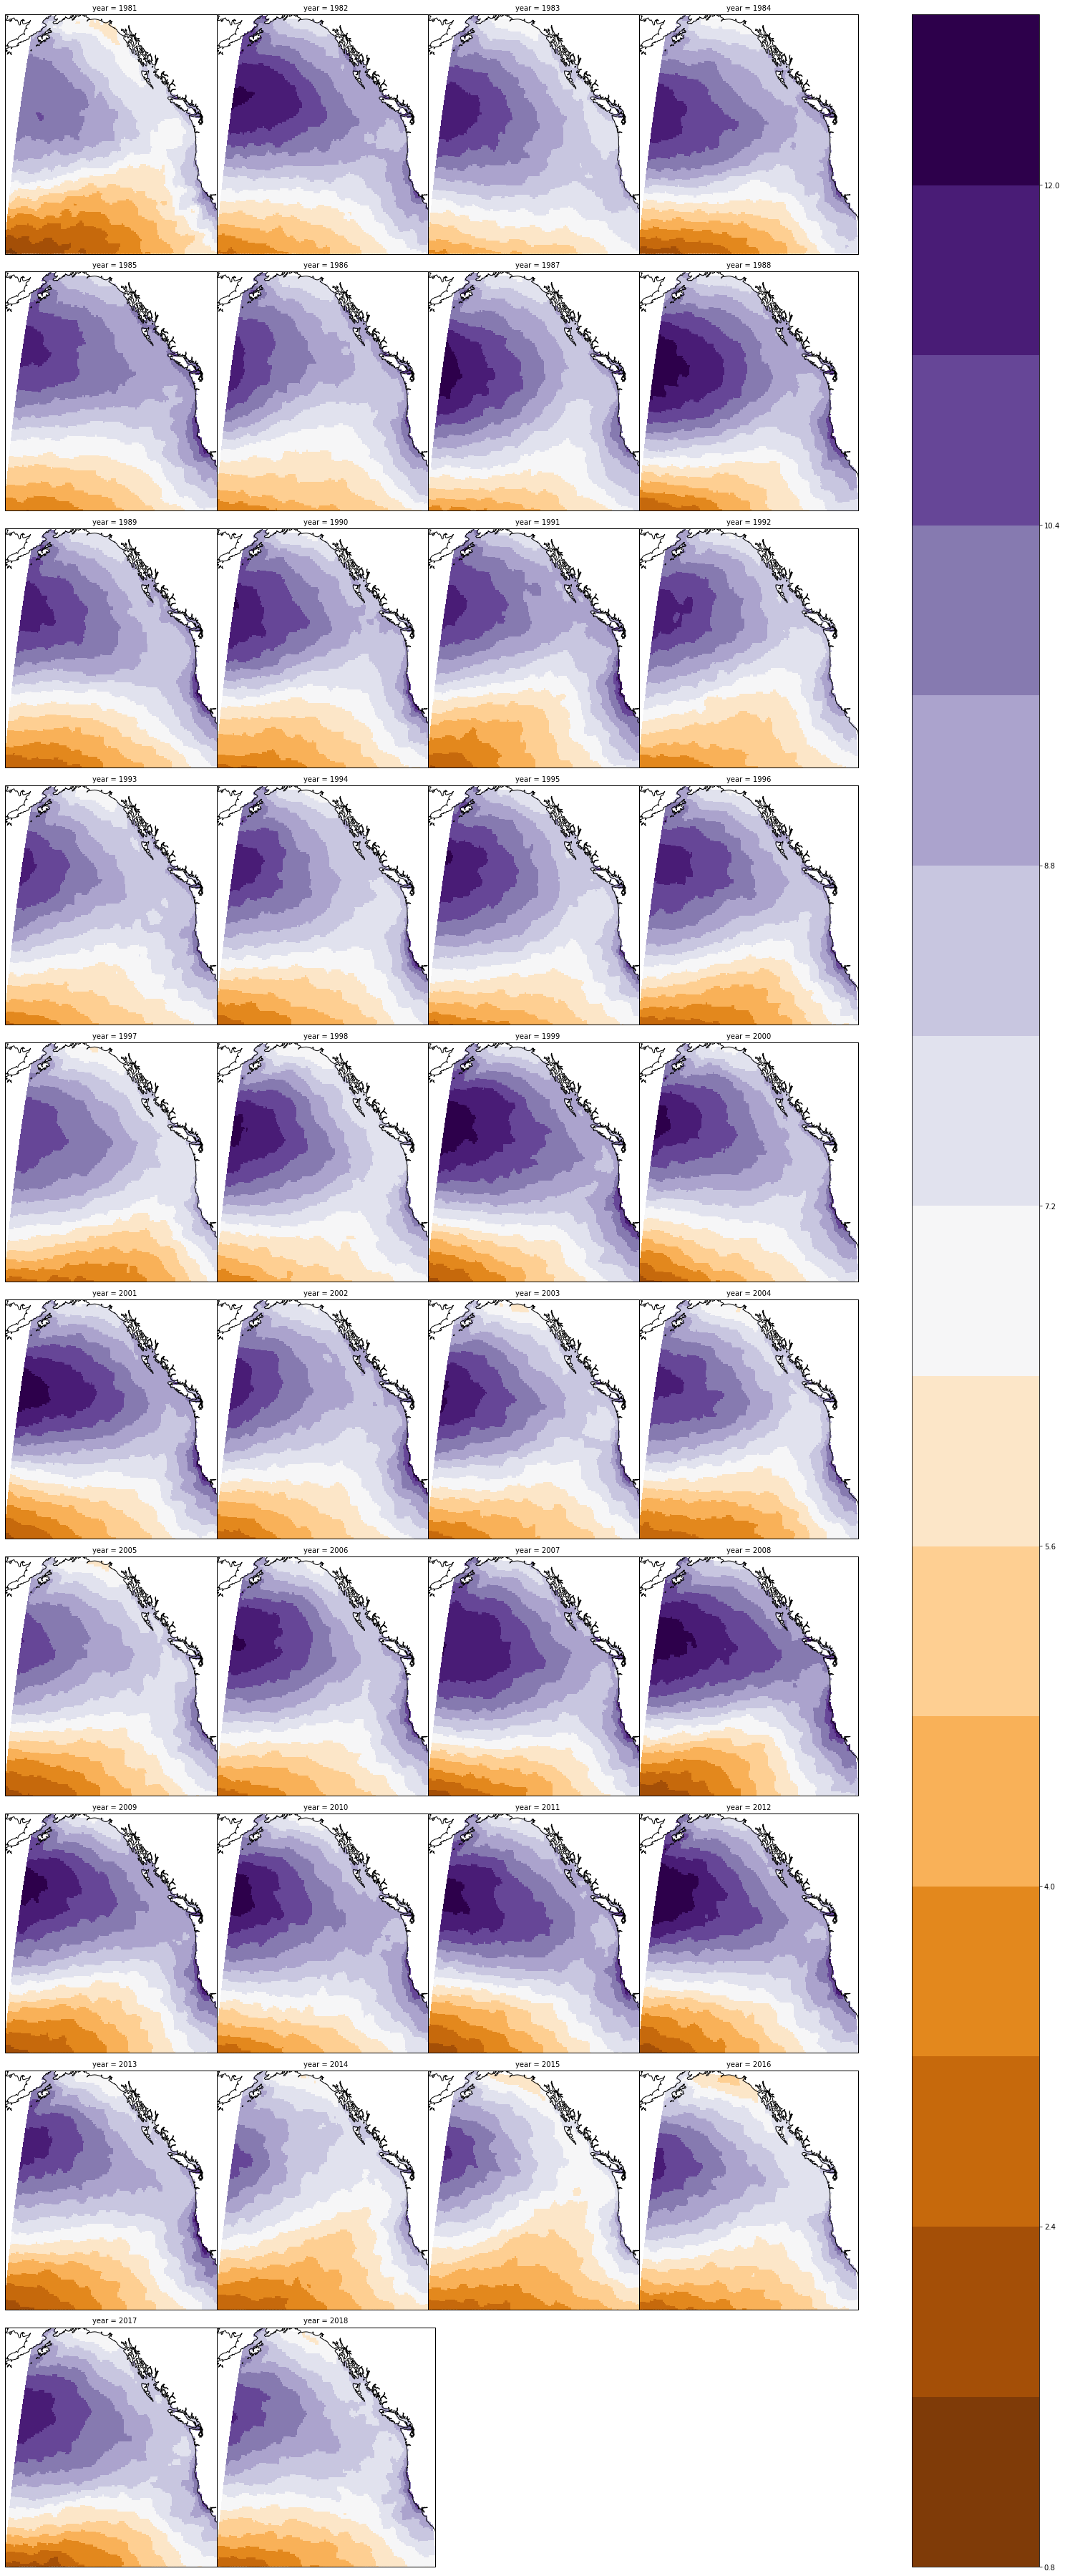

In [17]:
fg = departure \
    .groupby('time.year') \
    .mean(dim='time') \
    .plot.pcolormesh( 
        size=5, 
        levels=20, 
        col='year', col_wrap=4,
        cmap='PuOr', transform=ccrs.PlateCarree(), 
        subplot_kws={'projection': PLOT_MAP_PROJECTION}, 
    )
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()));

Text(0.5, 0.98, '2015')

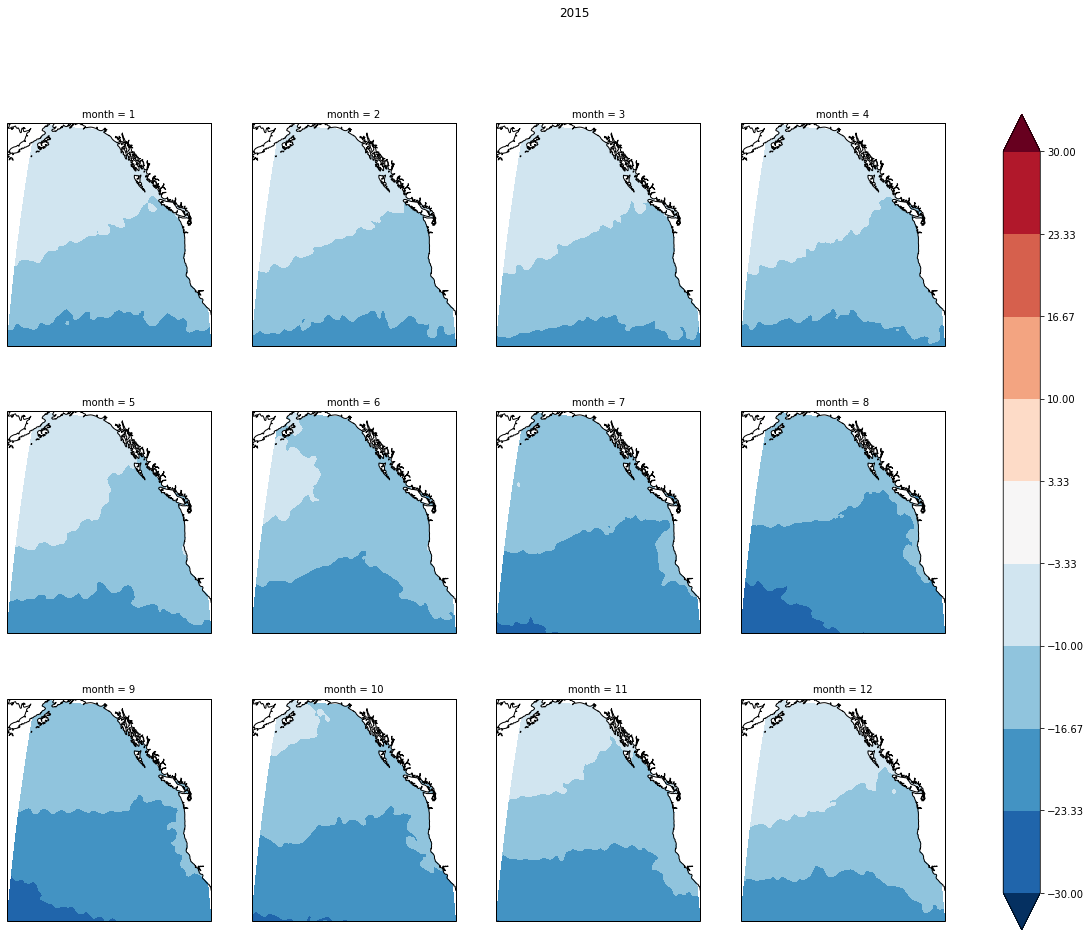

In [300]:
fg = departure.sel(time='2015').groupby('time.month').mean(dim='time').plot.contourf(
    col='month', col_wrap=4, size=5, vmax= 30, vmin=-30, levels=10, extend='both',
    transform=ccrs.PlateCarree(), cmap='RdBu_r',
    subplot_kws={'projection': PLOT_MAP_PROJECTION},
    cbar_kws={'label': "TPC difference from TPC(climatology)"}
)
list(map(lambda x: x.set_extent(extent), fg.axes.ravel()))
list(map(lambda x: x.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k'), fg.axes.ravel()))
# fg.cbar.set_label("TPC - TPC(climatology)")

fg.fig.suptitle("2015")

## Regional Trends over TIme

In [36]:
np.unique(mhws.where(mhw_only_filter).index_start.values)

array([62., 65., 66., ..., nan, nan, nan])

In [55]:
mhws.isel(time=[45, 56], lon=[]).time.values


array(['1981-10-16T00:00:00.000000000', '1981-10-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [77]:
def plot_mhw_times(lats=[], lons=[], times=[], ax=None):
    these_mhws =  mhws.isel(lat=lats, lon=lons, time=times)
    print(these_mhws)
    print(np.unique(these_mhws.index_start.values))
    starts = mhws.isel(time=np.unique(these_mhws.index_start.values)).time.values
    ends = mhws.isel(time=np.unique(these_mhws.index_end.values)).time.values
    return(list(zip(starts, ends)))

In [78]:
plot_mhw_times(lats=latband_isel)

<xarray.Dataset>
Dimensions:               (lat: 20, lon: 0, time: 0)
Coordinates:
  * lat                   (lat) float32 52.625 52.875 53.125 ... 57.125 57.375
  * lon                   (lon) float64 
  * time                  (time) datetime64[ns] 
Data variables:
    clim_seas             (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    clim_thresh           (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    duration              (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    index_end             (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    index_peak            (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    index_start           (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    intensity_cumulative  (lat, lon, time) float64 dask.array<chunksize=(10, 0, 0), meta=np.ndarray>
    intensity_max        

[]

In [18]:
DURATION_THRESHOLD = 20
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= DURATION_THRESHOLD)
non_mhw_filter = ~(mhws.mhw.notnull())

In [19]:
latband_isel = slice(90, 110)

In [20]:
mhw_only = oisst_pnw.isel(lat=latband_isel).where(mhw_only_filter, drop=True)
non_mhw = oisst_pnw.isel(lat=latband_isel).where(~mhw_only_filter)

IndexError: Index out of bounds 13636

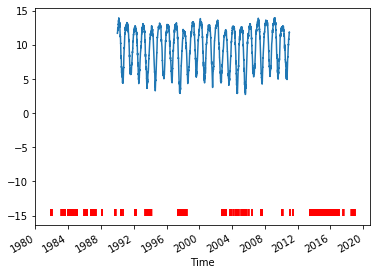

In [88]:
departure.isel(lat=latband_isel).mean(['lat', 'lon']).sel(time=slice('1990', '2010')).plot()
plt.vlines(mhw_only.isel(lat=latband_isel).time.values, ymin=-15, ymax=-14, color='red', alpha=0.2, )

these_mhws = mhws.where(mhw_only_filter).isel(lat=latband_isel).sel(time=slice('1990', '2010'))
starts = mhws.isel(time=np.unique(these_mhws.index_start.values - 1).astype(int)).time.values
ends = mhws.isel(time=np.unique(these_mhws.index_end.values - 1).astype(int)).time.values

for start, end in zip(starts, ends):
    plt.axvspan(start, end)
#     print(start, end )

plt.xlim(['2000', '2010'])

In [92]:
these_mhws.

TypeError: dropna() missing 1 required positional argument: 'dim'

In [22]:
climatology_difference = topt.Topt - mhws.clim_seas 

(731947.0, 733773.0)

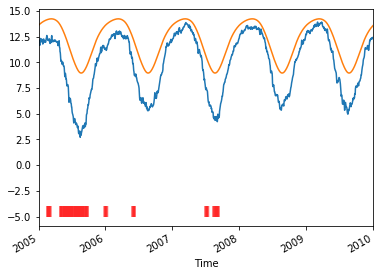

In [27]:
departure.isel(lat=latband_isel).mean(['lat', 'lon']).sel(time=slice('1990', '2020')).plot()
climatology_difference.isel(lat=latband_isel).mean(['lat', 'lon']).sel(time=slice('1990', '2020')).plot()

plt.vlines(mhw_only.time.values, ymin=-5, ymax=-4, color='red', alpha=0.2, )
plt.xlim(['2005', '2010'])

In [24]:
detriment_ratio =(departure / climatology_difference).persist()

(731947.0, 733773.0)

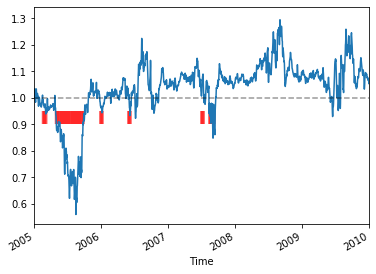

In [30]:
detriment_ratio.isel(lat=latband_isel).mean(['lat', 'lon']).sel(time=slice('2005', '2010')).plot()
plt.vlines(mhw_only.isel(lat=latband_isel).time.values, ymin=0.9, ymax=0.95, color='red', alpha=0.2, )

plt.axhline(1, color='k', linestyle='--', alpha=0.4)
plt.xlim(['2005', '2010'])

In [31]:
detriment_difference =(departure  - climatology_difference).compute()

(731947.0, 733773.0)

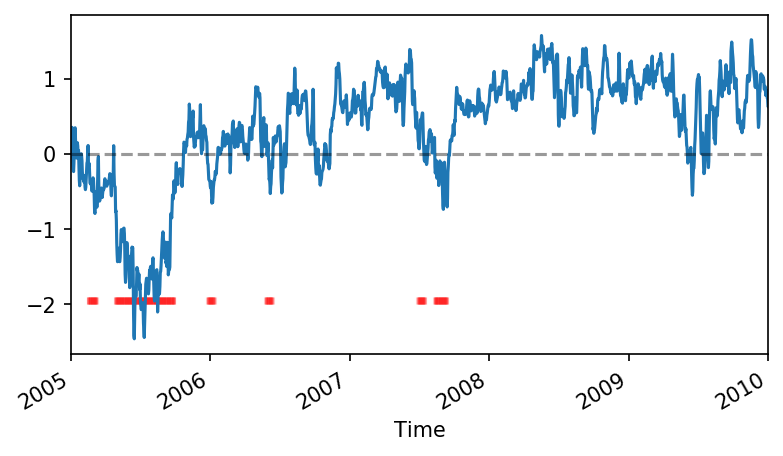

In [33]:
plt.figure(figsize=(6,3), dpi=150)
detriment_difference.isel(lat=latband_isel).mean(['lat', 'lon']).sel(time=slice('2005', '2010')).plot()
plt.vlines(mhw_only.isel(lat=latband_isel).time.values, ymin=-2, ymax=-1.9, color='red', alpha=0.2, )

plt.axhline(0, color='k', linestyle='--', alpha=0.4)
plt.xlim(['2005', '2010'])

## MHW vs Non MHW Times

In [361]:
mhw_only = oisst_pnw.where(mhw_only_filter, drop=True)
non_mhw = oisst_pnw.where(~mhw_only_filter)

In [371]:
diff_mhw = detriment_difference.where(mhw_only_filter, drop=True).mean(['lat', 'lon', 'time'])
diff_nomhw = detriment_difference.where(~mhw_only_filter).mean(['lat', 'lon', 'time'])